In [1]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt

from src.dataset import get_dataloaders
from src.models import CustomCNN, get_resnet18
from src.train import train_model
from src.evaluate import evaluate_model, plot_confusion_matrix, plot_training_history
from src.utils import predict_from_dataset, visualize_prediction_from_dataset, visualize_dataset_samples

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
DATA_DIR = '../data'
BATCH_SIZE = 16  # Reduced for better gradient updates with small dataset

train_loader, val_loader, test_loader, class_names = get_dataloaders(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    val_split=0.15,
    test_split=0.15
)

print(f"Number of classes (leagues): {len(class_names)}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

In [3]:
print("Leagues in dataset:")
for i, league in enumerate(class_names, 1):
    print(f"{i:2d}. {league}")

Leagues in dataset:
 1. Austria - Bundesliga
 2. Belgium - Jupiler Pro League
 3. Bulgaria - efbet Liga
 4. Croatia - SuperSport HNL
 5. Czech Republic - Chance Liga
 6. Denmark - Superliga
 7. England - Premier League
 8. France - Ligue 1
 9. Germany - Bundesliga
10. Greece - Super League 1
11. Hungary - Nemzeti Bajnokság
12. Israel - Ligat ha'Al
13. Italy - Serie A
14. Netherlands - Eredivisie
15. Norway - Eliteserien
16. Poland - PKO BP Ekstraklasa
17. Portugal - Liga Portugal
18. Romania - SuperLiga
19. Russia - Premier Liga
20. Scotland - Scottish Premiership
21. Serbia - Super liga Srbije
22. Spain - LaLiga
23. Sweden - Allsvenskan
24. Switzerland - Super League
25. Türkiye - Süper Lig
26. Ukraine - Premier Liga


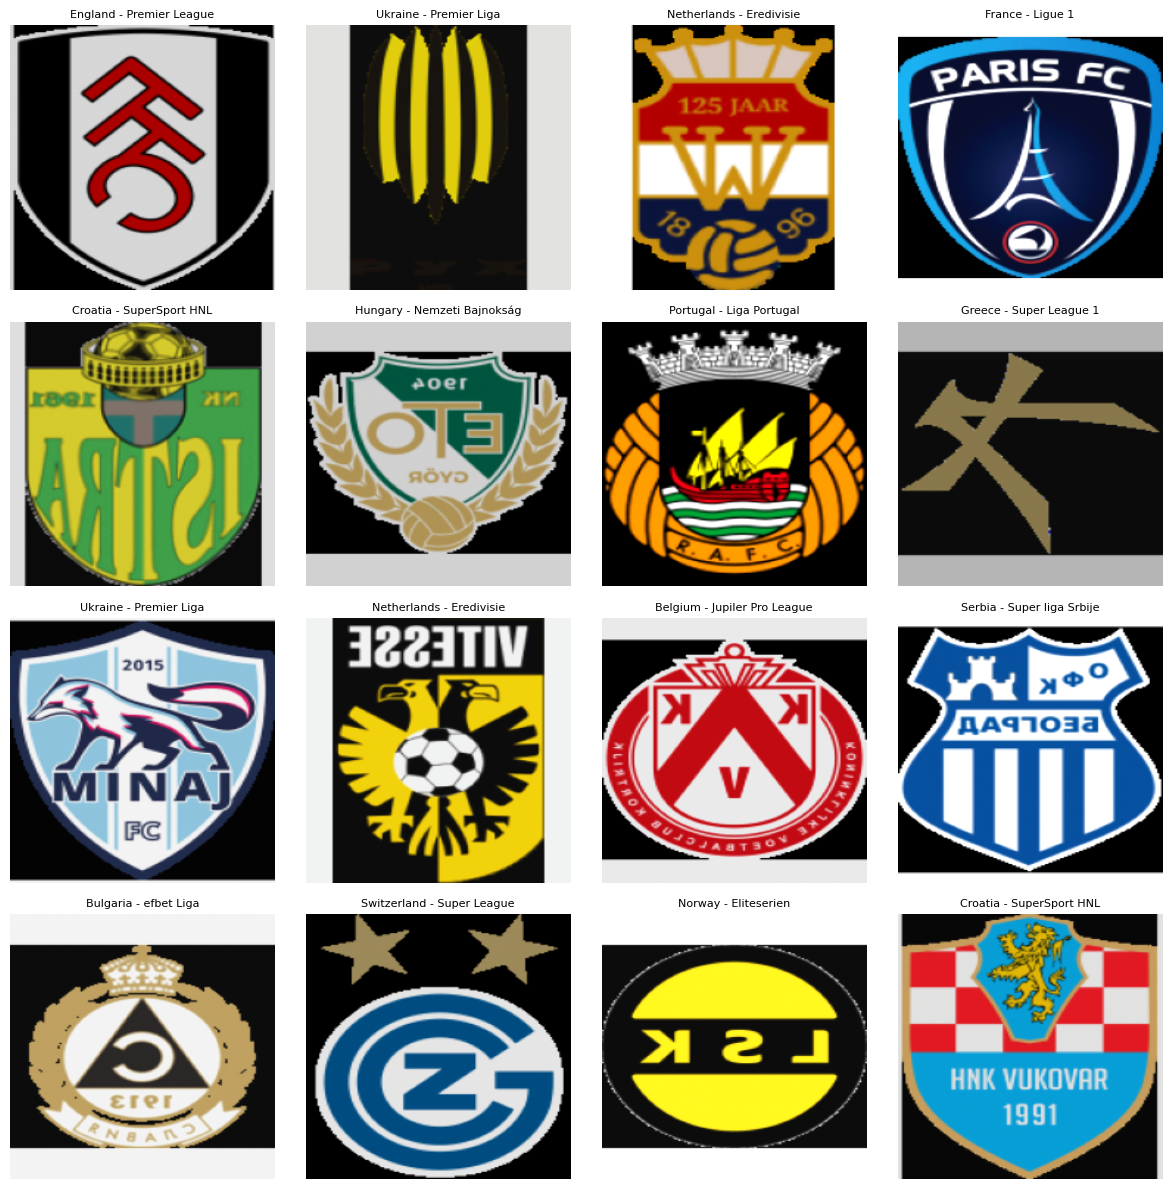

In [4]:
visualize_dataset_samples(train_loader.dataset.dataset, class_names, n_samples=16)

In [ ]:
# ====================================================================
# SECTION 4: TRAIN CUSTOM CNN WITH MULTIPLE CONFIGURATIONS
# ====================================================================
# Probamos 3 configuraciones para encontrar la mejor combinación de epochs y lr
# Con dataset pequeño (579 imágenes, 24 ligas), diferentes configs pueden tener resultados MUY distintos

# CAMBIOS APLICADOS para combatir overfitting:
# - Learning rates MÁS BAJOS (reducidos a la mitad)
# - MÁS epochs (para converger lentamente)
# - Weight decay agregado (L2 regularization)
# - Dropout aumentado a 0.65 en CustomCNN
# - Augmentation agresivo en dataset.py
# - Batch size reducido a 16

# Configuraciones a probar para CustomCNN (entrena desde cero, sin conocimiento previo):
# Config 1 - AGRESIVA: lr medio-bajo, más epochs
#   - Aprende más lento que antes (0.0005 vs 0.001)
#   - Menos riesgo de overfitting temprano
# Config 2 - BALANCEADA: lr bajo, más epochs  
#   - Convergencia gradual y estable
#   - Esperamos mejor generalización
# Config 3 - CONSERVADORA: lr muy bajo, muchas epochs
#   - Aprende muy lento pero converge de forma óptima
#   - Mínimo riesgo de overfitting

cnn_configs = [
    {'name': 'Agresiva', 'epochs': 25, 'lr': 0.0005, 'weight_decay': 1e-4},      # Lr reducido, más epochs
    {'name': 'Balanceada', 'epochs': 30, 'lr': 0.0001, 'weight_decay': 1e-4},   # Punto medio óptimo
    {'name': 'Conservadora', 'epochs': 35, 'lr': 0.00005, 'weight_decay': 1e-3}  # Muy lenta, weight decay alto
]

# Guardaremos los resultados de cada configuración para compararlos
cnn_results = []

print("="*70)
print("CUSTOM CNN - PRUEBA DE CONFIGURACIONES (OPTIMIZADO)")
print("="*70)
print("Mejoras aplicadas:")
print("  - Learning rates reducidos 50%")
print("  - Epochs aumentados +10")
print("  - Weight decay (L2 regularization)")
print("  - Dropout 0.65 (aumentado)")
print("  - Augmentation agresivo (rotation, zoom, color, perspective)")
print("  - Batch size 16 (reducido)")
print("="*70)

# Probamos cada configuración
for i, config in enumerate(cnn_configs, 1):
    print(f"\n{'='*70}")
    print(f"CONFIG {i}/3: {config['name']}")
    print(f"Epochs: {config['epochs']} | LR: {config['lr']} | Weight Decay: {config['weight_decay']}")
    print(f"{'='*70}")
    
    # Creamos un modelo nuevo para cada configuración (partimos desde cero cada vez)
    model = CustomCNN(num_classes=len(class_names))
    
    # Entrenamos con la configuración actual
    history = train_model(
        model,
        train_loader,
        val_loader,
        epochs=config['epochs'],
        lr=config['lr'],
        weight_decay=config['weight_decay'],
        device=DEVICE
    )
    
    # Guardamos los resultados: modelo entrenado + métricas + configuración usada
    cnn_results.append({
        'config': config,
        'model': model,
        'history': history,
        'final_val_acc': history['val_acc'][-1],  # Accuracy final en validación
        'final_val_loss': history['val_loss'][-1],  # Loss final en validación
        'overfitting': history['train_acc'][-1] - history['val_acc'][-1]  # Gap train-val (cuanto mayor, más overfitting)
    })
    
    print(f"\nResultados Config {config['name']}:")
    print(f"  - Val Accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"  - Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  - Overfitting (train_acc - val_acc): {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%")

print(f"\n{'='*70}")
print("CUSTOM CNN - Configuraciones completadas")
print(f"{'='*70}")

In [ ]:
# Visualizamos el progreso de entrenamiento de cada configuración del CustomCNN
# Esto nos ayuda a identificar overfitting, underfitting, o convergencia óptima

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Custom CNN - Comparación de Configuraciones', fontsize=16, fontweight='bold')

for i, result in enumerate(cnn_results):
    ax = axes[i]
    history = result['history']
    config = result['config']
    
    # Plot de accuracy (train vs validation)
    ax.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
    ax.set_title(f"{config['name']}\n(epochs={config['epochs']}, lr={config['lr']})")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [ ]:
# Seleccionamos la mejor configuración del CustomCNN
# Criterio: Mayor val_accuracy + menor overfitting (diferencia entre train y val)
# No siempre la que mejor va en train es la mejor, puede estar overfitteando

best_cnn = max(cnn_results, key=lambda x: x['final_val_acc'] - 0.3 * x['overfitting'])
# Penalizamos overfitting con factor 0.3: preferimos modelo que generalice bien

print("=" * 70)
print("MEJOR CONFIGURACIÓN - CUSTOM CNN")
print("=" * 70)
print(f"Configuración elegida: {best_cnn['config']['name']}")
print(f"  - Epochs: {best_cnn['config']['epochs']}")
print(f"  - Learning Rate: {best_cnn['config']['lr']}")
print(f"  - Val Accuracy: {best_cnn['final_val_acc']:.2f}%")
print(f"  - Val Loss: {best_cnn['final_val_loss']:.4f}")
print(f"  - Overfitting: {best_cnn['overfitting']:.2f}%")
print("=" * 70)

In [ ]:
# ====================================================================
# SECTION 5: TRAIN RESNET18 WITH MULTIPLE CONFIGURATIONS
# ====================================================================
# ResNet18 con transfer learning: YA sabe reconocer patrones de ImageNet (1M imágenes)
# Solo necesitamos ajustarlo a nuestras 24 ligas de fútbol

# CAMBIOS APLICADOS para combatir overfitting:
# - FREEZE de capas tempranas (conv1, bn1, layer1, layer2)
# - Solo entrenamos layer3, layer4, fc (capas profundas + clasificador)
# - Learning rates MÁS BAJOS
# - MÁS epochs
# - Weight decay agregado

# Configuraciones para ResNet18 (transfer learning, pesos preentrenados):
# Config 1 - ESTÁNDAR: Configuración conservadora con freeze
#   - lr muy bajo (0.00005) para no destruir pesos congelados
#   - Más epochs porque aprende más lento
# Config 2 - MODERADA: Más refinamiento
#   - lr ultra-bajo y más epochs
#   - Alto weight decay para regularización fuerte
# Config 3 - FINA: Máxima precisión
#   - lr mínimo para ajustes microscópicos
#   - Muchas epochs para convergencia óptima

resnet_configs = [
    {'name': 'Estándar', 'epochs': 20, 'lr': 0.00005, 'weight_decay': 1e-4},    # Lr reducido, más epochs
    {'name': 'Moderada', 'epochs': 25, 'lr': 0.00001, 'weight_decay': 1e-3},    # Muy bajo lr, alto decay
    {'name': 'Fina', 'epochs': 30, 'lr': 0.000005, 'weight_decay': 1e-3}        # Ultra-bajo lr
]

# Guardaremos los resultados de cada configuración
resnet_results = []

print("="*70)
print("RESNET18 (TRANSFER LEARNING) - PRUEBA DE CONFIGURACIONES (OPTIMIZADO)")
print("="*70)
print("Mejoras aplicadas:")
print("  - FREEZE capas tempranas (conv1, bn1, layer1, layer2)")
print("  - Solo entrenamos: layer3, layer4, fc")
print("  - Learning rates ultra-bajos (no destruir pesos ImageNet)")
print("  - Epochs aumentados (+10)")
print("  - Weight decay fuerte")
print("="*70)

# Probamos cada configuración
for i, config in enumerate(resnet_configs, 1):
    print(f"\n{'='*70}")
    print(f"CONFIG {i}/3: {config['name']}")
    print(f"Epochs: {config['epochs']} | LR: {config['lr']} | Weight Decay: {config['weight_decay']}")
    print(f"{'='*70}")
    
    # Creamos un modelo ResNet18 con pesos de ImageNet + freeze de capas tempranas
    model = get_resnet18(num_classes=len(class_names), pretrained=True, freeze_layers=True)
    
    # Entrenamos (fine-tuning: ajustamos solo las capas profundas)
    history = train_model(
        model,
        train_loader,
        val_loader,
        epochs=config['epochs'],
        lr=config['lr'],
        weight_decay=config['weight_decay'],
        device=DEVICE
    )
    
    # Guardamos resultados
    resnet_results.append({
        'config': config,
        'model': model,
        'history': history,
        'final_val_acc': history['val_acc'][-1],
        'final_val_loss': history['val_loss'][-1],
        'overfitting': history['train_acc'][-1] - history['val_acc'][-1]
    })
    
    print(f"\nResultados Config {config['name']}:")
    print(f"  - Val Accuracy: {history['val_acc'][-1]:.2f}%")
    print(f"  - Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  - Overfitting (train_acc - val_acc): {history['train_acc'][-1] - history['val_acc'][-1]:.2f}%")

print(f"\n{'='*70}")
print("RESNET18 - Configuraciones completadas")
print(f"{'='*70}")

In [ ]:
# Visualizamos el progreso de entrenamiento de cada configuración del ResNet18
# Transfer learning suele converger más rápido que entrenar desde cero

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ResNet18 (Transfer Learning) - Comparación de Configuraciones', fontsize=16, fontweight='bold')

for i, result in enumerate(resnet_results):
    ax = axes[i]
    history = result['history']
    config = result['config']
    
    # Plot de accuracy (train vs validation)
    ax.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
    ax.set_title(f"{config['name']}\n(epochs={config['epochs']}, lr={config['lr']})")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [ ]:
# Seleccionamos la mejor configuración del ResNet18
# Mismo criterio: Mayor val_accuracy + menor overfitting

best_resnet = max(resnet_results, key=lambda x: x['final_val_acc'] - 0.3 * x['overfitting'])

print("=" * 70)
print("MEJOR CONFIGURACIÓN - RESNET18")
print("=" * 70)
print(f"Configuración elegida: {best_resnet['config']['name']}")
print(f"  - Epochs: {best_resnet['config']['epochs']}")
print(f"  - Learning Rate: {best_resnet['config']['lr']}")
print(f"  - Val Accuracy: {best_resnet['final_val_acc']:.2f}%")
print(f"  - Val Loss: {best_resnet['final_val_loss']:.4f}")
print(f"  - Overfitting: {best_resnet['overfitting']:.2f}%")
print("=" * 70)

In [ ]:
# ====================================================================
# SECTION 6: EVALUATE MODELS ON TEST SET
# ====================================================================
# Evaluamos los mejores modelos seleccionados en el test set (datos nunca vistos)
# Métricas: accuracy, precision, recall, F1-score por cada liga

print("=" * 70)
print("EVALUACIÓN: MEJOR CUSTOM CNN")
print("=" * 70)
results_cnn = evaluate_model(best_cnn['model'], test_loader, class_names, device=DEVICE)

In [ ]:
print("\n" + "=" * 70)
print("EVALUACIÓN: MEJOR RESNET18")
print("=" * 70)
results_resnet = evaluate_model(best_resnet['model'], test_loader, class_names, device=DEVICE)

In [ ]:
# ====================================================================
# SECTION 7: FINAL COMPARISON
# ====================================================================
# Comparamos ambos modelos y determinamos el ganador final

print("\n" + "=" * 70)
print("COMPARACIÓN FINAL - TEST SET")
print("=" * 70)
print(f"Custom CNN ({best_cnn['config']['name']}): {results_cnn['accuracy']:.2f}%")
print(f"ResNet18 ({best_resnet['config']['name']}): {results_resnet['accuracy']:.2f}%")
print(f"\nMejora con Transfer Learning: {results_resnet['accuracy'] - results_cnn['accuracy']:.2f}%")
print("=" * 70)

# Seleccionamos el modelo ganador (mayor accuracy en test)
if results_resnet['accuracy'] > results_cnn['accuracy']:
    winner_name = f"ResNet18 ({best_resnet['config']['name']})"
    winner_model = best_resnet['model']
    winner_results = results_resnet
else:
    winner_name = f"Custom CNN ({best_cnn['config']['name']})"
    winner_model = best_cnn['model']
    winner_results = results_cnn

print(f"\nMODELO GANADOR: {winner_name}")
print(f"Test Accuracy: {winner_results['accuracy']:.2f}%")

In [ ]:
# ====================================================================
# SECTION 8: CONFUSION MATRIX
# ====================================================================
# Matriz de confusión del modelo ganador
# Muestra dónde el modelo se confunde: qué ligas clasifica mal y con qué las confunde

plot_confusion_matrix(
    winner_results['labels'],
    winner_results['predictions'],
    class_names,
    figsize=(14, 12)
)

In [ ]:
# ====================================================================
# SECTION 9: TEST PREDICTIONS
# ====================================================================
# Probamos el modelo ganador con una imagen aleatoria del test set
# Vemos las top-5 predicciones con sus probabilidades

import random

# Dataset de test (sin transformaciones de augmentation, solo normalización)
test_dataset = test_loader.dataset.dataset

# Seleccionamos una imagen aleatoria
random_idx = random.randint(0, len(test_dataset) - 1)

# Hacemos predicción con el modelo ganador
predictions, true_label, image = predict_from_dataset(
    test_dataset,
    winner_model,
    class_names,
    random_idx,
    device=DEVICE,
    top_k=5
)

print(f"True Label: {true_label}")
print("\nTop 5 predictions:")
for i, (league, prob) in enumerate(predictions, 1):
    print(f"{i}. {league}: {prob:.2f}%")

In [ ]:
# Visualizamos la predicción (imagen + top 3 predicciones + etiqueta real)
visualize_prediction_from_dataset(image, predictions[:3], true_label)

In [ ]:
# ====================================================================
# SECTION 10: SAVE BEST MODEL
# ====================================================================
# Guardamos el modelo ganador para uso futuro

MODEL_PATH = '../models/best_model.pth'
torch.save(winner_model.state_dict(), MODEL_PATH)

print("=" * 70)
print("MODELO GUARDADO")
print("=" * 70)
print(f"Modelo: {winner_name}")
print(f"Path: {MODEL_PATH}")
print(f"Test Accuracy: {winner_results['accuracy']:.2f}%")
print("=" * 70)